CWD: /Users/xinweichong/Desktop/NUS STUFF/EXCHANGE/Y3S1 (Uppsala)/Data Mining/Project

Loading WHO…

Loading World Bank…
Loaded frames (rows): {'Depression': 183, 'Suicide': 184, 'GDP': 258, 'HealthExp': 209, 'Internet': 186, 'Education': 119, 'Urban': 263, 'Unemployment': 235}
Merged dataset shape (inner): (103, 9)
Countries after merge: 103

Missingness summary (fraction of NaN per column):
Country         0.0
Depression      0.0
Suicide         0.0
GDP             0.0
HealthExp       0.0
Internet        0.0
Education       0.0
Urban           0.0
Unemployment    0.0
dtype: float64


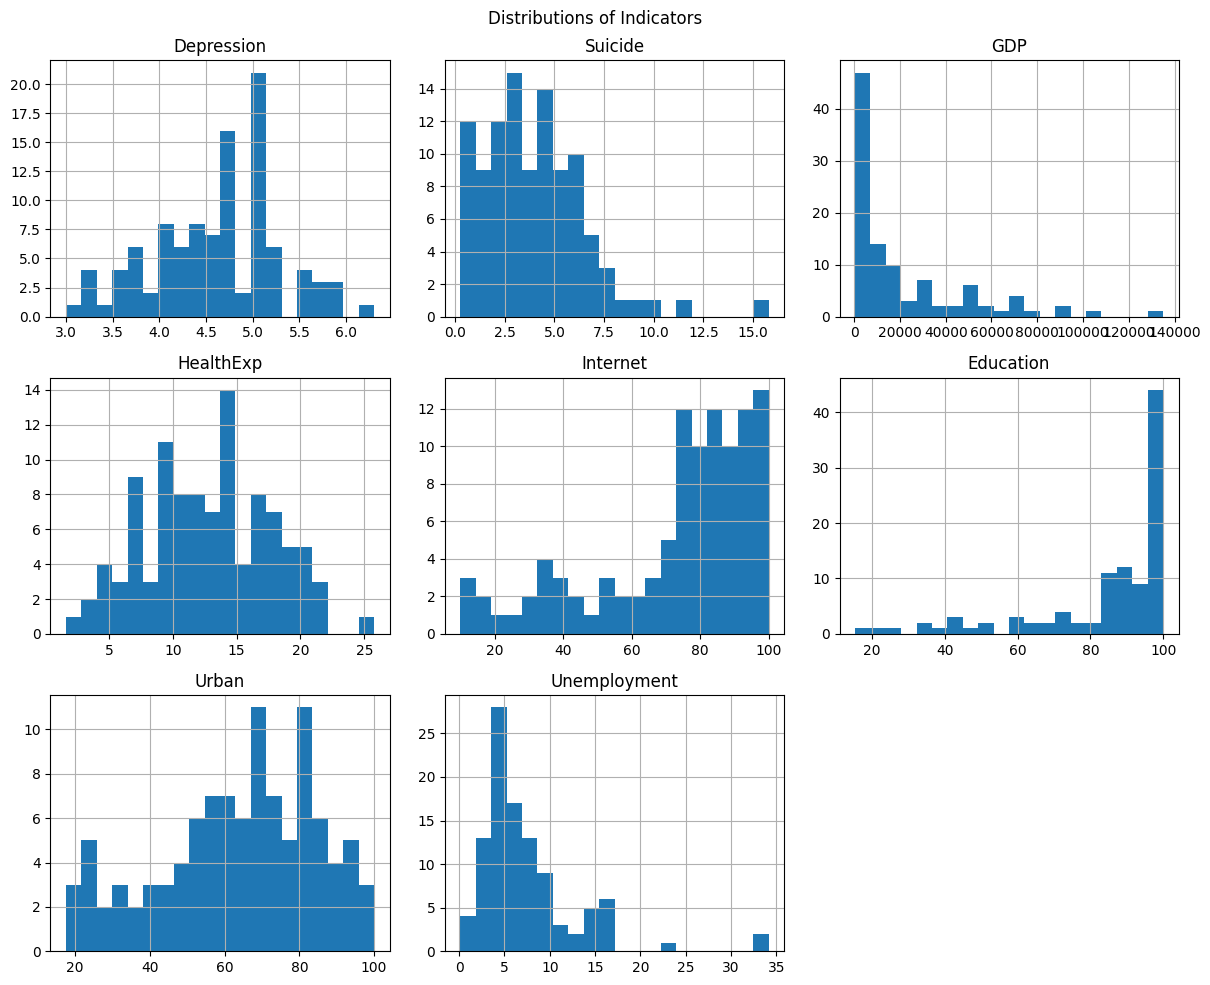

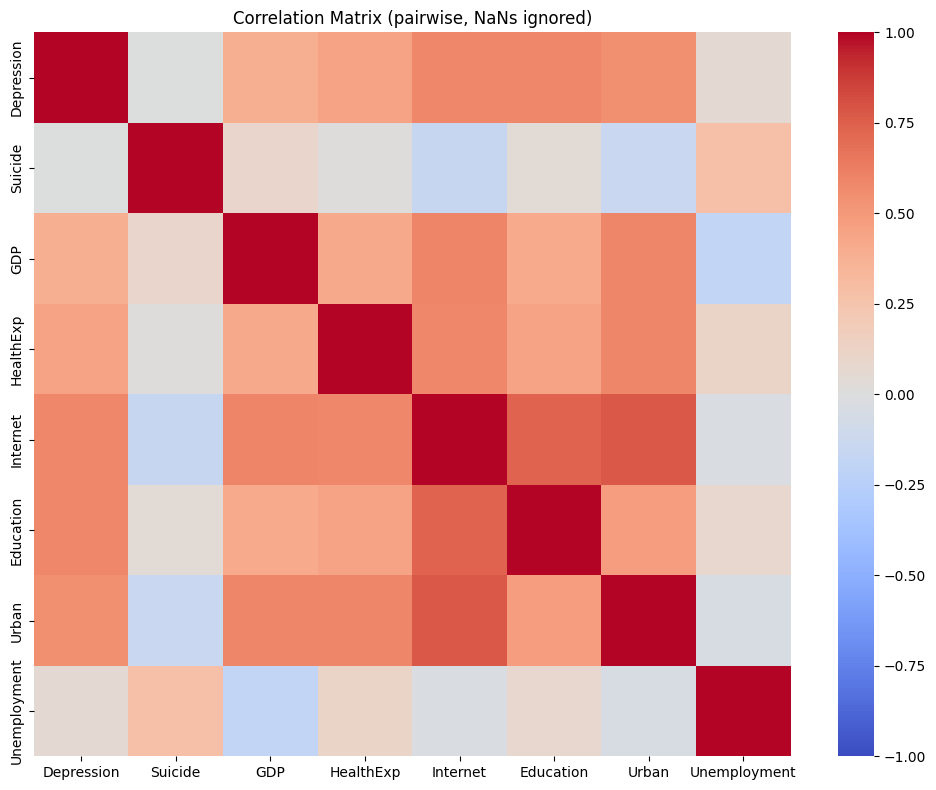

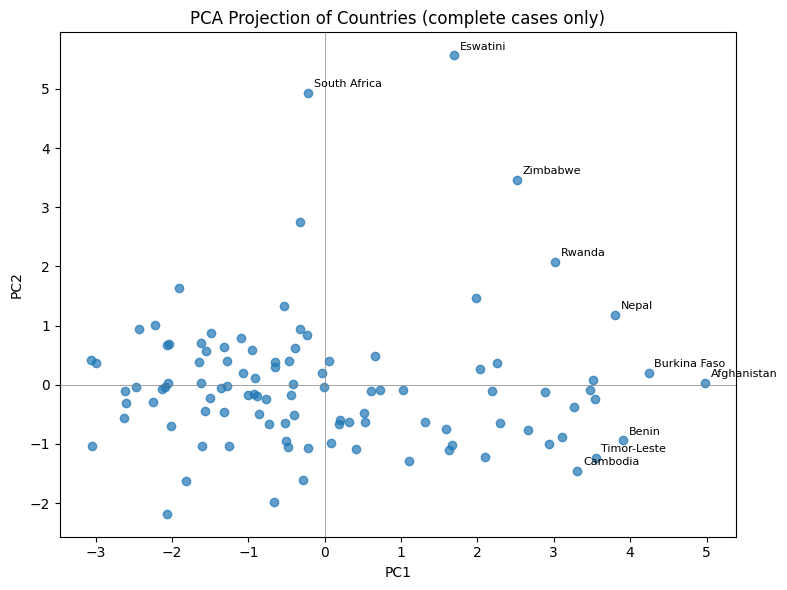

Explained variance ratio (PC1, PC2): [0.46972044 0.16732956]   — cumulative: 0.6370500029500776

Top absolute loadings on PC1:
                   PC1       PC2
Internet     -0.471677 -0.082052
Urban        -0.439777 -0.119034
Education    -0.400043  0.143646
Depression   -0.384343  0.102867
HealthExp    -0.375839  0.131398
GDP          -0.366314 -0.089865
Suicide       0.030129  0.656338
Unemployment  0.003766  0.701258

Top absolute loadings on PC2:
                   PC1       PC2
Unemployment  0.003766  0.701258
Suicide       0.030129  0.656338
Education    -0.400043  0.143646
HealthExp    -0.375839  0.131398
Urban        -0.439777 -0.119034
Depression   -0.384343  0.102867
GDP          -0.366314 -0.089865
Internet     -0.471677 -0.082052

Preprocessing complete. Saved as /Users/xinweichong/Desktop/NUS STUFF/EXCHANGE/Y3S1 (Uppsala)/Data Mining/Project/cleaned_dataset_final.csv


In [3]:
# ==============================================================
# WHO (Depression, Suicide) + World Bank indicators
# INNER merge, no global imputation
# EDA + PCA + (optional) Association Rules
# ==============================================================

from pathlib import Path
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# -----------------------------
# Config
# -----------------------------
DATA_DIR = "."           # same folder as your notebook/script
YEAR_WB  = "2021"
MERGE_HOW = "inner"      # intersection of countries
DO_PLOTS = True          # set False to skip plots

print("CWD:", Path(".").resolve())

# -----------------------------
# Utilities
# -----------------------------
def find_file(patterns):
    if isinstance(patterns, str):
        patterns = [patterns]
    for pat in patterns:
        p = Path(pat)
        if p.exists():
            return str(p)
        hits = glob.glob(pat)
        if hits:
            return hits[0]
    raise FileNotFoundError(f"No file matched any of: {patterns}")

def read_csv_any(path):
    encs = ["utf-8", "utf-8-sig", "latin1", "cp1252"]
    seps = [None, ",", ";", "\t"]  # None => sniff via python engine
    last = None
    for enc in encs:
        for sep in seps:
            try:
                if sep is None:
                    return pd.read_csv(path, encoding=enc, sep=sep, engine="python", on_bad_lines="skip")
                else:
                    return pd.read_csv(path, encoding=enc, sep=sep, engine="c", on_bad_lines="skip")
            except Exception as e:
                last = e
    raise last

def read_excel_any(path):
    try:
        return pd.read_excel(path)
    except Exception:
        return pd.read_excel(path, engine="openpyxl")

def read_table_any(path):
    suf = Path(path).suffix.lower()
    if suf in {".xlsx", ".xls"}:
        return read_excel_any(path)
    if suf in {".csv", ".txt"} or suf == "":
        try:
            return read_csv_any(path)
        except Exception:
            return read_excel_any(path)
    try:
        return read_csv_any(path)
    except Exception:
        return read_excel_any(path)

def normalize_country_names(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip().str.replace(r"\s+\(.*\)$", "", regex=True)
    fixes = {
        "United States of America": "United States",
        "Russian Federation": "Russia",
        "Viet Nam": "Vietnam",
        "Iran (Islamic Republic of)": "Iran",
        "Czechia": "Czech Republic",
        "Korea, Rep.": "South Korea",
        "Korea (Republic of)": "South Korea",
        "Korea, Dem. People’s Rep.": "North Korea",
        "Egypt, Arab Rep.": "Egypt",
        "Bahamas, The": "Bahamas",
        "Gambia, The": "Gambia",
        "Congo, Dem. Rep.": "DR Congo",
        "Congo, Rep.": "Congo",
        "Yemen, Rep.": "Yemen",
        "Syrian Arab Republic": "Syria",
        "Lao PDR": "Laos",
        "Hong Kong SAR, China": "Hong Kong",
        "Macao SAR, China": "Macao",
        "Brunei Darussalam": "Brunei",
    }
    return s.replace(fixes)

# -----------------------------
# WHO helpers (header & country detection)
# -----------------------------
_multi_sep = re.compile(r"[,\t;]+")

def _split_multi(line: str):
    return [p for p in _multi_sep.split(line) if p != ""]

def _read_text_lines(path: str):
    encs = ["utf-8", "utf-8-sig", "latin1", "cp1252"]
    for enc in encs:
        try:
            with open(path, "r", encoding=enc, errors="replace") as f:
                return f.readlines()
        except Exception:
            continue
    return []

def _reparse_from_header(filename: str, header_idx: int):
    encs = ["utf-8", "utf-8-sig", "latin1", "cp1252"]
    for enc in encs:
        try:
            return pd.read_csv(
                filename,
                engine="python",
                sep=r"[,\t;]+",
                header=header_idx,
                on_bad_lines="skip",
                dtype=str,
                encoding=enc,
            )
        except Exception:
            continue
    # last resort
    return pd.read_csv(filename, header=header_idx, engine="python", dtype=str)

def _choose_country_column(df: pd.DataFrame):
    # Prefer known names
    for c in ("Location", "Country", "SpatialDimValue"):
        if c in df.columns:
            return c
    # else guess based on being stringy & country-like
    sample_countries = set("""
        United States United Kingdom Canada Australia India China Japan Germany France Italy Spain
        Sweden Norway Finland Denmark Netherlands Belgium Switzerland Austria Ireland Portugal
        Brazil Argentina Chile Mexico Colombia Peru South Africa Nigeria Kenya Egypt Morocco
        Russia Ukraine Poland Czech Republic Greece Turkey Israel Saudi Arabia UAE Iran Iraq
        Indonesia Malaysia Thailand Vietnam Philippines Singapore South Korea North Korea Taiwan
        New Zealand Pakistan Bangladesh Sri Lanka Nepal Ethiopia Ghana Tanzania Algeria Tunisia
    """.split())
    best, best_hits = None, -1
    for col in df.columns:
        vals = df[col].astype(str).str.strip()
        alpha_ratio = vals.str.match(r"^[A-Za-z .,'-]+$").mean()
        if alpha_ratio < 0.5:
            continue
        hits = sum(v in sample_countries for v in vals.head(200))
        if hits > best_hits:
            best, best_hits = col, hits
    return best

# filename → exact WHO value column (as you specified)
WHO_VALUE_COL = {
    "depression_prevalence": "FactValueString",
    "suicide_rates": "FactValueForMeasure",
}

def load_who_exact(pattern, out_col):
    fn = find_file(pattern)
    df = read_table_any(fn)

    # If not properly headered, detect header row containing Location & Period/Value
    if not any(c in df.columns for c in ["Location", "Country", "SpatialDimValue"]):
        lines = _read_text_lines(fn)
        header_idx = None
        cand_vals = ("FactValueNumeric", "FactValueString", "FactValueForMeasure", "NumericValue", "Value", "ValueNumeric")
        for i, line in enumerate(lines):
            parts = _split_multi(line.strip())
            if "Location" in parts and (("Period" in parts) or any(c in parts for c in cand_vals)):
                header_idx = i
                break
        if header_idx is not None:
            df = _reparse_from_header(fn, header_idx)

    country_col = _choose_country_column(df)
    if not country_col:
        print(f"[WHO] {fn}: no Location/Country-like column; skipping")
        return pd.DataFrame(columns=["Country", out_col])

    # Choose value column by mapping (file name)
    lower = Path(fn).name.lower()
    mapped = None
    for key, col in WHO_VALUE_COL.items():
        if key in lower and col in df.columns:
            mapped = col
            break
    if not mapped:
        print(f"[WHO] {fn}: expected value column not found; columns: {list(df.columns)[:12]}")
        return pd.DataFrame(columns=["Country", out_col])

    # Latest year if Period exists
    if "Period" in df.columns:
        df = df.loc[:, ~df.columns.duplicated()].copy()
        df["Period"] = pd.to_numeric(df["Period"], errors="coerce")
        df = df.dropna(subset=["Period"])
        df = df.sort_values([country_col, "Period"]).groupby(country_col, as_index=False).tail(1)

    # Convert to numeric safely (handles 1,234.56 vs 12,3 & stray dashes)
    s = df[mapped].astype(str).str.strip().replace({"–": None, "-": None, "": None})
    s = np.where(pd.Series(s).str.contains(r"\.", regex=True),
                 pd.Series(s).str.replace(",", "", regex=False),
                 pd.Series(s).str.replace(",", ".", regex=False))
    vals = pd.to_numeric(s, errors="coerce")

    out = pd.DataFrame({
        "Country": normalize_country_names(df[country_col]),
        out_col: vals
    }).dropna(subset=[out_col])
    return out

# -----------------------------
# World Bank loader
# -----------------------------
def load_wb_csv(pattern, out_col, year=YEAR_WB, country_col="Country Name"):
    fn = find_file(pattern)
    df = read_table_any(fn)
    # WB CSVs often have 4 metadata rows
    if not any(str(c).isdigit() for c in df.columns):
        try:
            df = pd.read_csv(fn, skiprows=4)
        except Exception:
            pass
    years = sorted([c for c in df.columns if str(c).isdigit()], key=int)
    if not years:
        print(f"[WB] {fn}: no year columns; skipping")
        return pd.DataFrame(columns=["Country", out_col])
    y = year if year in df.columns else years[-1]
    out = df[[country_col, y]].copy()
    out.columns = ["Country", out_col]
    out["Country"] = normalize_country_names(out["Country"])
    out[out_col] = pd.to_numeric(out[out_col], errors="coerce")
    out = out.dropna(subset=[out_col])
    return out

# -----------------------------
# File patterns (ONLY the datasets you want)
# -----------------------------
WHO_DEPRESSION = [f"{DATA_DIR}/depression_prevalence*"]
WHO_SUICIDE    = [f"{DATA_DIR}/suicide_rates*"]

WB_GDP        = [f"{DATA_DIR}/gdp_per_capita*"]
WB_HEALTH     = [f"{DATA_DIR}/health_expenditure*"]
WB_INTERNET   = [f"{DATA_DIR}/internet_usage*"]
WB_EDUCATION  = [f"{DATA_DIR}/education_attainment*"]
WB_URBAN      = [f"{DATA_DIR}/urban_population*"]
WB_UNEMPLOY   = [f"{DATA_DIR}/unemployment*"]

# -----------------------------
# Run: load + merge
# -----------------------------
print("\nLoading WHO…")
depr_df = load_who_exact(WHO_DEPRESSION, "Depression")
suic_df = load_who_exact(WHO_SUICIDE, "Suicide")

print("\nLoading World Bank…")
gdp_df   = load_wb_csv(WB_GDP,       "GDP")
hexp_df  = load_wb_csv(WB_HEALTH,    "HealthExp")
net_df   = load_wb_csv(WB_INTERNET,  "Internet")
edu_df   = load_wb_csv(WB_EDUCATION, "Education")
urb_df   = load_wb_csv(WB_URBAN,     "Urban")
unemp_df = load_wb_csv(WB_UNEMPLOY,  "Unemployment")

dfs = [depr_df, suic_df, gdp_df, hexp_df, net_df, edu_df, urb_df, unemp_df]
names = ["Depression","Suicide","GDP","HealthExp","Internet","Education","Urban","Unemployment"]
nonempty = [(n, df) for n, df in zip(names, dfs) if df is not None and len(df) > 0]
print("Loaded frames (rows):", {n: len(df) for n, df in nonempty})

# INNER merge (only countries present in ALL selected datasets)
if not nonempty:
    merged = pd.DataFrame(columns=["Country"])
else:
    merged = nonempty[0][1]
    for _, df in nonempty[1:]:
        merged = merged.merge(df, on="Country", how=MERGE_HOW)

print(f"Merged dataset shape ({MERGE_HOW}): {merged.shape}")
if "Country" in merged.columns:
    print("Countries after merge:", merged["Country"].nunique())

# ---------- No global imputation; just summarize missingness ----------
if merged.shape[0] > 0:
    print("\nMissingness summary (fraction of NaN per column):")
    miss = merged.isna().mean().sort_values(ascending=False)
    print(miss)

# ---------- Quick EDA (no filling) ----------
if DO_PLOTS and merged.shape[0] > 0:
    merged.drop(columns=["Country"]).hist(figsize=(12, 10), bins=20)
    plt.suptitle("Distributions of Indicators")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))
    corr = merged.drop(columns=["Country"]).corr(numeric_only=True)
    sns.heatmap(corr, annot=False, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title("Correlation Matrix (pairwise, NaNs ignored)")
    plt.tight_layout()
    plt.show()

# ---------- PCA preview with outlier labels ----------
if DO_PLOTS and merged.shape[0] > 1:
    features = merged.drop(columns=["Country"])
    features_num = features.select_dtypes(include=[np.number])

    # Keep only complete cases for PCA
    complete_pca = features_num.dropna(axis=0)
    dropped = features_num.shape[0] - complete_pca.shape[0]
    if dropped > 0:
        print(f"PCA: dropping {dropped} rows with missing values out of {features_num.shape[0]} total.")

    if complete_pca.shape[0] >= 2:
        # Fit PCA
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(complete_pca)
        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(X_scaled)

        # Build a scores DataFrame with countries
        scores = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=complete_pca.index)
        scores["Country"] = merged.loc[complete_pca.index, "Country"].values

        # Compute outlier-ness as Euclidean distance from the centroid in PC space
        pc_mean = scores[["PC1", "PC2"]].mean(axis=0)
        dists = np.linalg.norm(scores[["PC1", "PC2"]] - pc_mean, axis=1)
        scores["dist_from_center"] = dists

        # How many labels to show? Tweak this:
        OUTLIER_K = 10

        # Pick top-K farthest points
        to_label = scores.nlargest(OUTLIER_K, "dist_from_center")

        # Plot
        plt.figure(figsize=(8, 6))
        plt.scatter(scores["PC1"], scores["PC2"], alpha=0.7)
        plt.title("PCA Projection of Countries (complete cases only)")
        plt.xlabel("PC1")
        plt.ylabel("PC2")

        # Add labels with a small offset to reduce overlap
        # (Simple jitter; for fancier collision-avoidance consider 'adjustText' library)
        for _, r in to_label.iterrows():
            plt.annotate(
                r["Country"],
                (r["PC1"], r["PC2"]),
                xytext=(4, 4), textcoords="offset points",
                fontsize=8
            )

        # Helpful axes lines
        plt.axhline(0, lw=0.5, color="grey")
        plt.axvline(0, lw=0.5, color="grey")

        plt.tight_layout()
        plt.show()

        # (Optional) print variance explained + top loadings for interpretation
        print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_[:2],
              "  — cumulative:", pca.explained_variance_ratio_[:2].sum())
        loadings = pd.DataFrame(
            pca.components_[:2].T,
            columns=["PC1", "PC2"],
            index=complete_pca.columns
        )
        print("\nTop absolute loadings on PC1:")
        print(loadings.reindex(loadings["PC1"].abs().sort_values(ascending=False).index).head(8))
        print("\nTop absolute loadings on PC2:")
        print(loadings.reindex(loadings["PC2"].abs().sort_values(ascending=False).index).head(8))

    else:
        print("PCA: not enough complete rows to plot.")

# ---------- Save (no imputation applied) ----------
out_path = Path("cleaned_dataset_final.csv")
merged.to_csv(out_path, index=False)
print(f"\nPreprocessing complete. Saved as {out_path.resolve()}")



Using 103 countries and 8 numeric features (complete cases).

=== Top 10 runs by silhouette ===
                method   k  pca  silhouette  n_clusters  eps  min_samples      var
              KMeans++ 3.0  2.0    0.556744           3  NaN          NaN 0.637050
              KMeans++ 2.0  2.0    0.540734           2  NaN          NaN 0.637050
    Agglomerative-Ward 3.0  2.0    0.540392           3  NaN          NaN 0.637050
    Agglomerative-Ward 2.0  2.0    0.535086           2  NaN          NaN 0.637050
 Agglomerative-AvgManh 3.0  2.0    0.534074           3  NaN          NaN 0.637050
Agglomerative-Complete 2.0  2.0    0.503912           2  NaN          NaN 0.637050
Agglomerative-Complete 3.0  2.0    0.495941           3  NaN          NaN 0.637050
 Agglomerative-AvgManh 4.0  2.0    0.493485           4  NaN          NaN 0.637050
 Agglomerative-AvgManh 2.0  2.0    0.486203           2  NaN          NaN 0.637050
              KMedoids 2.0  3.0    0.475991           2  NaN          NaN 

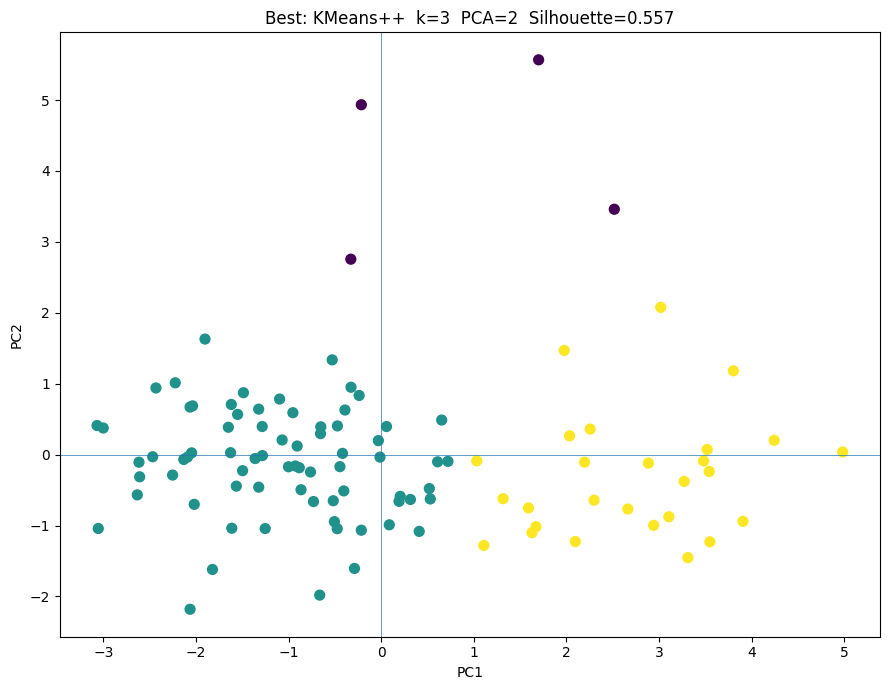

In [ ]:
# ==============================================================
# Unsupervised Auto-Tuner (Standardization only)
# - StandardScaler only (no log, no drop-corr)
# - Tries PCA dims: None, 2, 4, 6
# - Algorithms: KMeans++, KMedoids (optional), Agglomerative (Ward/Avg-Manhattan/Complete),
#               DBSCAN with eps grid from k-NN distances
# - Selects best by silhouette, saves outputs, plots best
# ==============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn_extra.cluster import KMedoids

HAS_KMEDOIDS = True

# -----------------------------
# Load data (complete cases only)
# -----------------------------
df = pd.read_csv("cleaned_dataset_final.csv")

X_full = df.drop(columns=["Country"]).select_dtypes(include=[np.number])
mask_complete = X_full.notna().all(axis=1)
X = X_full.loc[mask_complete].copy()
countries = df.loc[mask_complete, "Country"].reset_index(drop=True)
X.reset_index(drop=True, inplace=True)

print(f"Using {len(countries)} countries and {X.shape[1]} numeric features (complete cases).")

# -----------------------------
# Helpers
# -----------------------------
def to_scaled(Xdf: pd.DataFrame):
    scaler = StandardScaler()
    Xs = scaler.fit_transform(Xdf)
    return Xs, scaler

def do_pca(X_scaled: np.ndarray, n_components=None, random_state=42):
    if n_components is None:
        return X_scaled, None, None
    pca = PCA(n_components=n_components, random_state=random_state)
    Xp = pca.fit_transform(X_scaled)
    return Xp, pca, pca.explained_variance_ratio_.sum()

def safe_silhouette(X, labels):
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters <= 1:
        return np.nan, n_clusters
    try:
        return silhouette_score(X, labels), n_clusters
    except Exception:
        return np.nan, n_clusters

def dbscan_eps_grid(X, k=4, percentiles=(60, 65, 70, 75, 80, 85, 90, 92, 94, 96, 98)):
    nn = NearestNeighbors(n_neighbors=k).fit(X)
    dists, _ = nn.kneighbors(X)
    kth = np.sort(dists[:, -1])
    vals = [np.percentile(kth, p) for p in percentiles]
    return sorted(set(np.round(vals, 4)))

# -----------------------------
# Search space
# -----------------------------
pca_grid = [None, 2, 3, 4, 5, 6]
k_grid = list(range(2, 11))

results = []
best = {"score": -1, "record": None}

# -----------------------------
# Standardize once
# -----------------------------
X_scaled, scaler = to_scaled(X)

# -----------------------------
# Grid search (PCA × algorithms × k/params)
# -----------------------------
for n_pc in pca_grid:
    X_work, pca, var_sum = do_pca(X_scaled, n_components=n_pc)

    # --- KMeans++ ---
    for k in k_grid:
        km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
        labels = km.fit_predict(X_work)
        sil, ncl = safe_silhouette(X_work, labels)
        results.append({
            "method": "KMeans++", "k": k, "pca": n_pc, "silhouette": sil,
            "n_clusters": ncl, "var": var_sum, "labels": labels, "model": km, "X_work": X_work
        })
        if (sil if not np.isnan(sil) else -1) > best["score"]:
            best = {"score": sil if not np.isnan(sil) else -1, "record": results[-1]}

    # --- KMedoids ---
    for k in k_grid:
        kmdo = KMedoids(n_clusters=k, metric="euclidean", random_state=42)
        labels = kmdo.fit_predict(X_work)
        sil, ncl = safe_silhouette(X_work, labels)
        results.append({
            "method": "KMedoids", "k": k, "pca": n_pc, "silhouette": sil,
            "n_clusters": ncl, "var": var_sum, "labels": labels, "model": kmdo, "X_work": X_work
        })
        if (sil if not np.isnan(sil) else -1) > best["score"]:
            best = {"score": sil if not np.isnan(sil) else -1, "record": results[-1]}

    # --- Agglomerative: Ward (euclidean) ---
    for k in k_grid:
        ag = AgglomerativeClustering(n_clusters=k, linkage="ward")
        labels = ag.fit_predict(X_work)
        sil, ncl = safe_silhouette(X_work, labels)
        results.append({
            "method": "Agglomerative-Ward", "k": k, "pca": n_pc, "silhouette": sil,
            "n_clusters": ncl, "var": var_sum, "labels": labels, "model": ag, "X_work": X_work
        })
        if (sil if not np.isnan(sil) else -1) > best["score"]:
            best = {"score": sil if not np.isnan(sil) else -1, "record": results[-1]}

    # --- Agglomerative: average + manhattan ---
    for k in k_grid:
        agm = AgglomerativeClustering(n_clusters=k, linkage="average", metric="manhattan")
        labels = agm.fit_predict(X_work)
        sil, ncl = safe_silhouette(X_work, labels)
        results.append({
            "method": "Agglomerative-AvgManh", "k": k, "pca": n_pc, "silhouette": sil,
            "n_clusters": ncl, "var": var_sum, "labels": labels, "model": agm, "X_work": X_work
        })
        if (sil if not np.isnan(sil) else -1) > best["score"]:
            best = {"score": sil if not np.isnan(sil) else -1, "record": results[-1]}

    # --- Agglomerative: complete + euclidean ---
    for k in k_grid:
        agc = AgglomerativeClustering(n_clusters=k, linkage="complete", metric="euclidean")
        labels = agc.fit_predict(X_work)
        sil, ncl = safe_silhouette(X_work, labels)
        results.append({
            "method": "Agglomerative-Complete", "k": k, "pca": n_pc, "silhouette": sil,
            "n_clusters": ncl, "var": var_sum, "labels": labels, "model": agc, "X_work": X_work
        })
        if (sil if not np.isnan(sil) else -1) > best["score"]:
            best = {"score": sil if not np.isnan(sil) else -1, "record": results[-1]}

    # --- DBSCAN: eps grid from k-NN distances (min_samples grid) ---
    for min_samples in (4, 5, 6):
        eps_list = dbscan_eps_grid(X_work, k=min_samples)
        for eps in eps_list:
            dbs = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbs.fit_predict(X_work)
            sil, ncl = safe_silhouette(X_work, labels)
            results.append({
                "method": "DBSCAN", "k": None, "pca": n_pc, "silhouette": sil,
                "n_clusters": ncl, "var": var_sum, "labels": labels, "model": dbs,
                "X_work": X_work, "eps": eps, "min_samples": min_samples
            })
            if (sil if not np.isnan(sil) else -1) > best["score"]:
                best = {"score": sil if not np.isnan(sil) else -1, "record": results[-1]}

# -----------------------------
# Results summary
# -----------------------------
res_df = pd.DataFrame(results)
res_df_sorted = res_df.sort_values(by=["silhouette"], ascending=False)
print("\n=== Top 10 runs by silhouette ===")
display_cols = ["method", "k", "pca", "silhouette", "n_clusters", "eps", "min_samples", "var"]
print(res_df_sorted[display_cols].head(10).to_string(index=False))

# Save full leaderboard
res_df_sorted.to_csv("clustering_leaderboard.csv", index=False)
print("\nFull leaderboard saved to clustering_leaderboard.csv")

# -----------------------------
# Best model details
# -----------------------------
best_rec = best["record"]
print("\n=== Best configuration ===")
for key in ["method","k","pca","var","silhouette","n_clusters","eps","min_samples"]:
    if key in best_rec:
        print(f"{key:>12}: {best_rec[key]}")

labels_best = best_rec["labels"]
X_best = best_rec["X_work"]

# Attach labels back to countries
out = pd.DataFrame({"Country": countries, "Cluster": labels_best})
out.to_csv("country_clusters_best.csv", index=False)
print("\nBest clustering saved to country_clusters_best.csv")

# Cluster summaries on original scale
X_used = X.copy()
X_used["Cluster"] = labels_best
summary = X_used.groupby("Cluster").mean(numeric_only=True)
counts = X_used["Cluster"].value_counts().sort_index()

print("\n=== Cluster sizes ===")
print(counts.to_string())

print("\n=== Cluster means (original features) ===")
print(summary.round(2).to_string())

# List countries per cluster (up to 12 per line)
for cl in sorted(np.unique(labels_best)):
    members = out.loc[out["Cluster"] == cl, "Country"].tolist()
    print(f"\nCluster {cl} ({len(members)} countries):")
    for i in range(0, len(members), 12):
        print("  " + ", ".join(members[i:i+12]))

# -----------------------------
# Plot best result in 2D PCA for visualization
# -----------------------------
# If the best run already used PCA with >=2 components, reuse its first 2 PCs,
# otherwise compute PCA(2) freshly on the standardized data for plotting only.
if best_rec["pca"] is not None and best_rec["pca"] >= 2:
    X_plot = X_best[:, :2]
    pc1_lab, pc2_lab = "PC1", "PC2"
else:
    pca2 = PCA(n_components=2, random_state=42)
    X_plot = pca2.fit_transform(X_scaled)
    pc1_lab, pc2_lab = "PC1", "PC2"

plt.figure(figsize=(9,7))
plt.scatter(X_plot[:,0], X_plot[:,1], c=labels_best, s=50)
plt.title(f"Best: {best_rec['method']}  k={best_rec.get('k','-')}  "
          f"PCA={best_rec['pca']}  Silhouette={best_rec['silhouette']:.3f}")
plt.xlabel(pc1_lab)
plt.ylabel(pc2_lab)
plt.axhline(0, lw=0.5)
plt.axvline(0, lw=0.5)
plt.tight_layout()
plt.show()